In [1]:
#code for image classification using tensorflow and keras
#import libraries

import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt


In [2]:
#import flower photos from google storage
import pathlib
data_dir = tf.keras.utils.get_file(origin='https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',fname='flower_photos',untar=True)
data_dir = pathlib.Path(data_dir)
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)


228813984/228813984 [==============================] - 47s 0us/step
3670


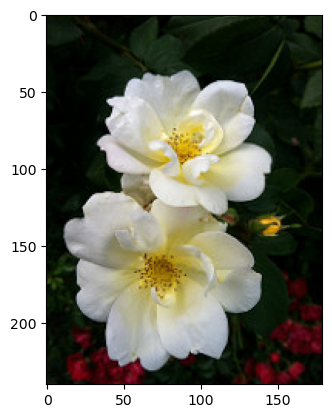

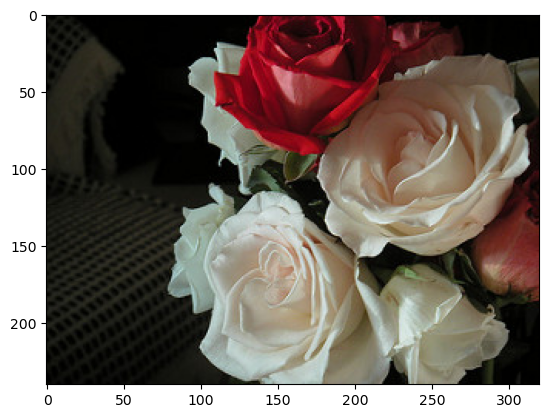

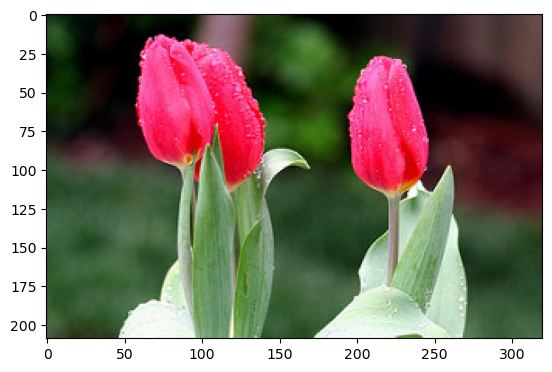

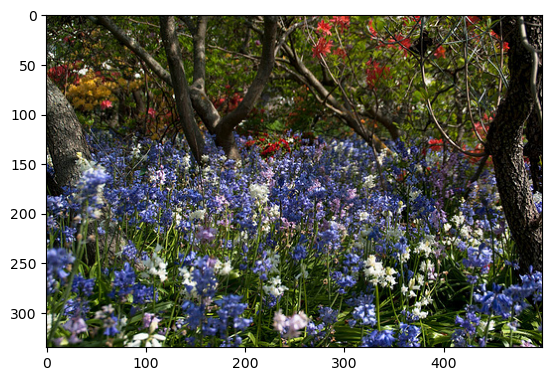

In [3]:
#display 2 rose and 2 tulips images
roses = list(data_dir.glob('roses/*'))
tulips = list(data_dir.glob('tulips/*'))
batch_size = 32
img_height = 180
img_width = 180
#display 2 rose and 2 tulips images
for i in range(2):
  img = plt.imread(str(roses[i]))
  plt.imshow(img)
  plt.show()
for i in range(2):
    img = plt.imread(str(tulips[i]))
    plt.imshow(img)
    plt.show()

In [4]:
#load images using keras.preprocessing
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir,validation_split=0.2,subset='training',seed=123,image_size=(img_height,img_width),batch_size=batch_size)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir,validation_split=0.2,subset='validation',seed=123,image_size=(img_height,img_width),batch_size=batch_size)
class_names = train_ds.class_names
print(class_names)


Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.
['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


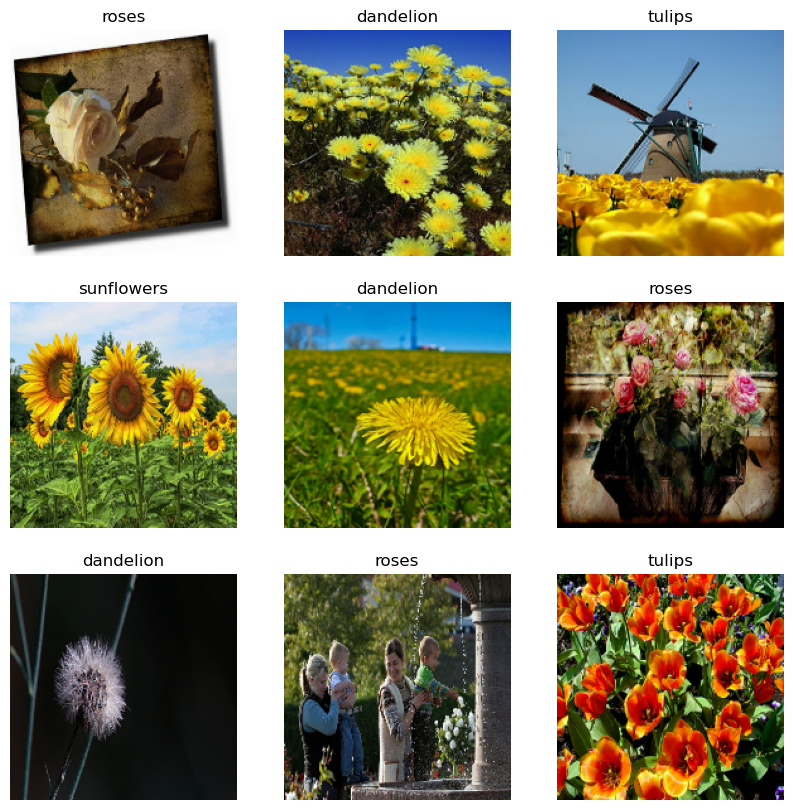

In [5]:
#visualize the data
plt.figure(figsize=(10,10))
for images,labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')

In [6]:
#standardize the data
normalization_layer = keras.layers.experimental.preprocessing.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x,y:(normalization_layer(x),y))
image_batch,label_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image),np.max(first_image))


0.0 1.0


In [7]:
#configure the dataset for performance
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [9]:
# #visualize training results
# acc = history.history['accuracy']
# val_acc = history.history['val_accuracy']
# loss=history.history['loss']
# val_loss=history.history['val_loss']
# epochs_range = range(epochs)
# plt.figure(figsize=(8,8))
# plt.subplot(1,2,1)
# plt.plot(epochs_range,acc,label='Training Accuracy')
# plt.plot(epochs_range,val_acc,label='Validation Accuracy')
# plt.legend(loc='lower right')
# plt.title('Training and Validation Accuracy')
# plt.subplot(1,2,2)
# plt.plot(epochs_range,loss,label='Training Loss')
# plt.plot(epochs_range,val_loss,label='Validation Loss')
# plt.legend(loc='upper right')
# plt.title('Training and Validation Loss')
# plt.show()

NameError: name 'history' is not defined

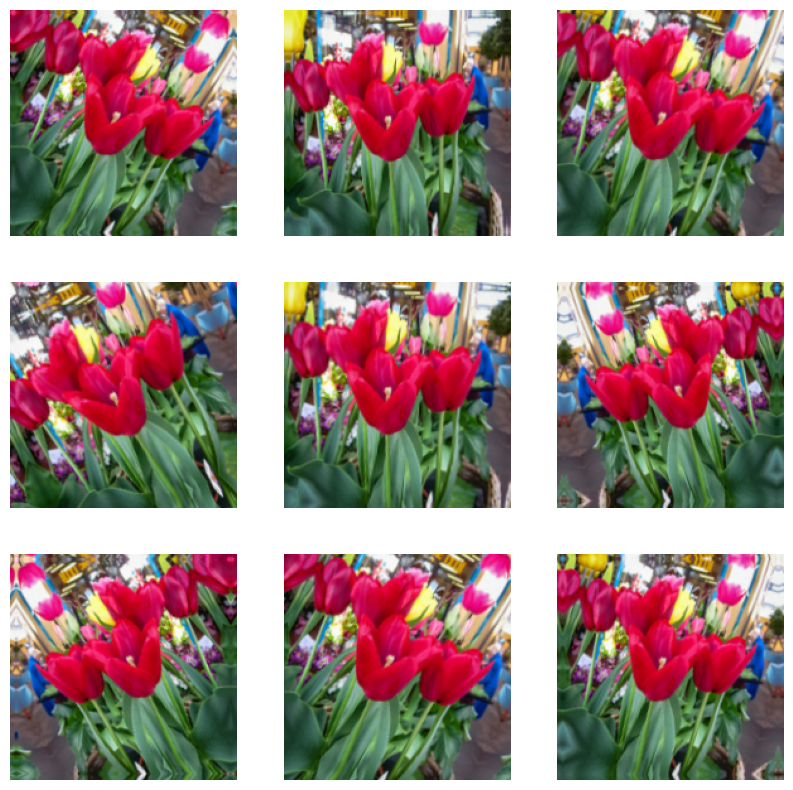

In [10]:
#overfitting
#data augmentation
data_augmentation = keras.Sequential([
    keras.layers.experimental.preprocessing.RandomFlip('horizontal',input_shape=(img_height,img_width,3)),
    keras.layers.experimental.preprocessing.RandomRotation(0.1),
    keras.layers.experimental.preprocessing.RandomZoom(0.1)
])
plt.figure(figsize=(10,10))
for images,_ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3,3,i+1)
        plt.imshow(augmented_images[0].numpy().astype('uint8'))
        plt.axis('off')

In [11]:
#dropout
model = tf.keras.Sequential([
    data_augmentation,
    keras.layers.experimental.preprocessing.Rescaling(1./255),
    keras.layers.Conv2D(16,3,padding='same',activation='relu'),
    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(32,3,padding='same',activation='relu'),
    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(64,3,padding='same',activation='relu'),
    keras.layers.MaxPooling2D(),
    keras.layers.Dropout(0.2),
    keras.layers.Flatten(),
    keras.layers.Dense(128,activation='relu'),
    keras.layers.Dense(num_classes)
])
model.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])
model.summary()
epochs = 15
history = model.fit(train_ds,validation_data=val_ds,epochs=epochs)


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

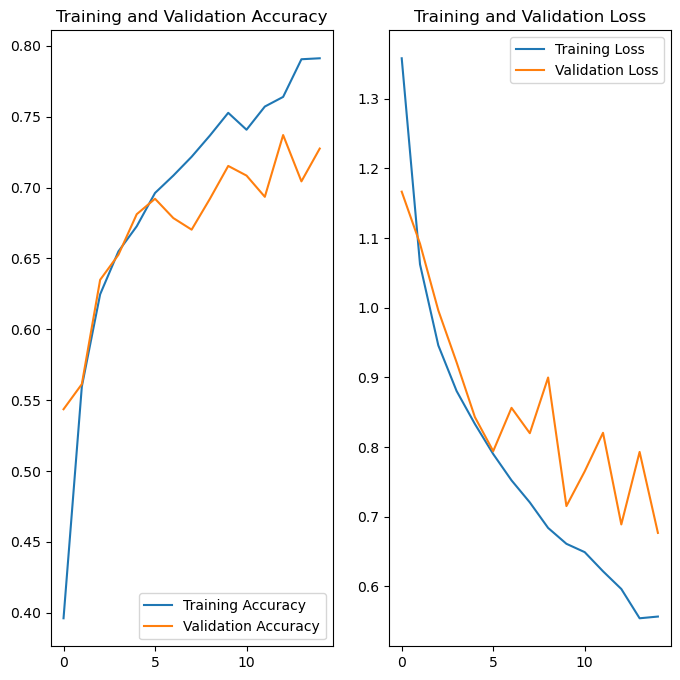

In [12]:
#visualize training results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']
epochs_range = range(epochs)
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(epochs_range,acc,label='Training Accuracy')
plt.plot(epochs_range,val_acc,label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.subplot(1,2,2)
plt.plot(epochs_range,loss,label='Training Loss')
plt.plot(epochs_range,val_loss,label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [13]:
#save and load the model
model.save('saved_model/my_model')
new_model = tf.keras.models.load_model('saved_model/my_model')
new_model.summary()
#check its accuracy
loss,acc = new_model.evaluate(val_ds,verbose=2)
print('Restored model,accuracy: {:5.2f}%'.format(100*acc))
#save the model for web deployment
model.save('flowers.h5')
#load the model
from keras.models import load_model
model = load_model('flowers.h5')

INFO:tensorflow:Assets written to: saved_model/my_model\assets


INFO:tensorflow:Assets written to: saved_model/my_model\assets


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

In [14]:
#predict on new data
sunflower_url = 'https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg'
sunflower_path = tf.keras.utils.get_file('Red_sunflower',origin=sunflower_url)
img = keras.preprocessing.image.load_img(sunflower_path,target_size=(img_height,img_width))
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array,0)
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print('This image most likely belongs to {} with a {:.2f} percent confidence.'.format(class_names[np.argmax(score)],100*np.max(score)))

1/1 [==============================] - 0s 399ms/step
This image most likely belongs to sunflowers with a 88.61 percent confidence.
